# Measuring how fast towels dry using an infra-red camera, experiment 3
How fast do different brands of towels dry? A dutch television program asked me to come up with a measurement to determine if "fast drying towels" do indeed dry faster than regular (cotton) towels.

This notebook describes the third in a serie of four experiments done. See the notebook for the second experiment for extensive documentation about the experimental setup and analyses in English. The first notebook has the same extensive documentation in Dutch.

In [1]:
#!pip install opencv-python

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import pandas as pd
from IPython.display import Video

In [3]:
#This is the video file. This is not shipped with this repository,
# If you want to work with this data, download the video at: 
# dx.doi.org/10.5281/zenodo.8167168
fileName = 'Droogtest ronde 3.mp4'

In [4]:

Video(fileName,width=550)

In [5]:
#from the above movie, determine point where recording starts, in milliseconds
startTime = 2 * 60 * 1000 

In [6]:
#as a test to see if we can get information from this file, get the dimensions
v = cv2.VideoCapture(fileName)
w = int(v.get(cv2.CAP_PROP_FRAME_WIDTH))    
h = int(v.get(cv2.CAP_PROP_FRAME_HEIGHT))
v.release()
print('Dimensions:',w,h)

Dimensions: 1920 1200


In [7]:
#open the file and skip to the good part
v = cv2.VideoCapture(fileName)
while v.get(cv2.CAP_PROP_POS_MSEC) < (startTime):
    v.read()

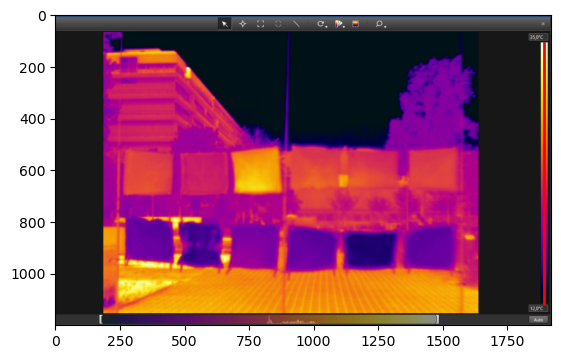

In [8]:
### these values found by plotting and looking at indexes
colorBarYTop = 107 
colorBarYBottom = 1112
colorbarX = 1890

#get one image to determine colorscale
success, image = v.read()
#convert to RGB
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#plot to see of correct
plt.imshow(img)
x = [colorbarX, colorbarX]
y = [colorBarYTop, colorBarYBottom]
plt.plot(x, y, color="red", linewidth=2)

In [9]:

colorBarTempMinMax = [[12.0, 35.0],
                      [12.0, 28.0],
                      [12.0, 25.0]]

colorbarTimeCodes = [(0 * 3600 + 0 * 60 + 0) * 1000,
                     (0 * 3600 +54 * 60 +20) * 1000,
                     (0 * 3600 +54 * 60 +34) * 1000,
                     (2 * 3600 + 0 * 60 + 0) * 1000,
]

colorBarValues = img[colorBarYTop:colorBarYBottom,colorbarX,:]

colorBarCounter = 0;

def getTempAxis(colorBarValues,colorBarTempMinMax):
    return np.linspace(colorBarTempMinMax[1],colorBarTempMinMax[0],len(colorBarValues)) 
#note the swapped indices! high temp at low pixel index

tempAxis = getTempAxis(colorBarValues,colorBarTempMinMax[colorBarCounter])
colorBarCounter = colorBarCounter + 1


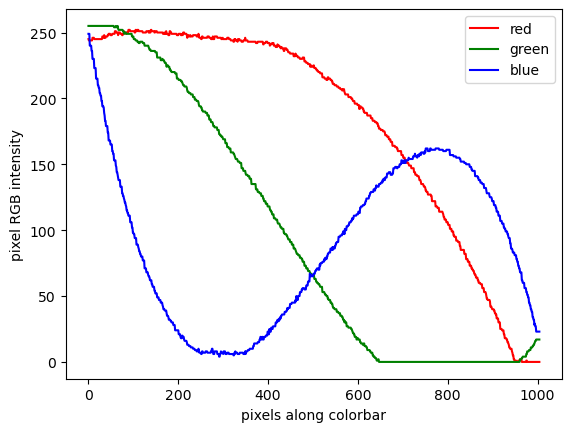

In [10]:
plt.plot(colorBarValues[:,0],'r',
         colorBarValues[:,1],'g',
         colorBarValues[:,2],'b')
plt.legend(['red','green','blue'])
plt.xlabel('pixels along colorbar')
plt.ylabel('pixel RGB intensity')
plt.savefig('figures/measurement3/ColorBarMeasurement3.png', dpi = 300)

In [11]:
#function to determine temperature of a single RGB pixel value, based on the colorbar.
    
def getTempFromRGB(targetRGB,colorBarValues, tempAxis):
    obj = np.linalg.norm([256,256,256]) #max value of difference between pixels
    temp = []
    for i in range(len(colorBarValues)):
        objPixel = np.linalg.norm(targetRGB-colorBarValues[i])
        if (objPixel < obj):
            obj = objPixel
            temp = tempAxis[i]
    return temp

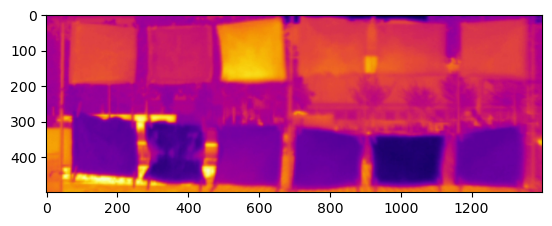

In [12]:
#plot frame again to gauge where the towels are
plt.imshow(img[500:1000,200:1600,:])

In [13]:
towelTopLeftList = [[240+60, 500+50],
                    [240+70, 500+320],
                    [240+270, 500+55],
                    [240+270, 500+340],
                    [240+480, 500+50],
                    [240+470, 500+340],
                    [240+710, 500+40],
                    [240+710, 500+360],
                    [240+940, 500+45],
                    [240+940, 500+360],
                    [240+1160, 500+50],
                    [240+1170, 500+360],
                   ]
towelDescriprion = ['1 droog','1 nat',
                    '2 droog','2 nat',
                    '3 droog','3 nat',
                    '4 droog','4 nat',
                    '5 droog','5 nat',
                    '6 droog','6 nat',
                   ]

towelSize = [100,100]

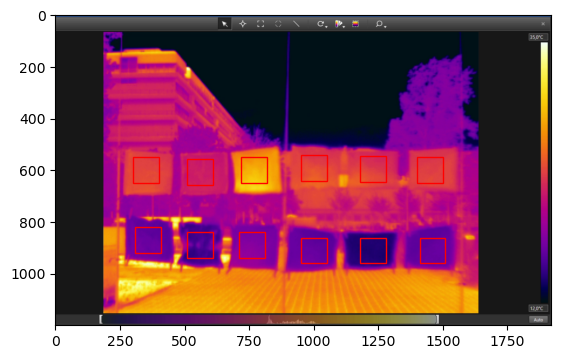

In [14]:
# Create figure and axes
fig, ax = plt.subplots()
ax.imshow(img)
# Create a Rectangle patch
for towelTopLeft in towelTopLeftList:
    rect = patches.Rectangle(towelTopLeft, towelSize[0],towelSize[1], linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)

plt.savefig('figures/measurement3/towelLocation3.png',dpi = 300)

In [15]:
tempAllTowels = pd.DataFrame(columns=towelDescriprion)
time = []


In [16]:
while v.isOpened():
    success, image = v.read()
    if success:
        
        msec = v.get(cv2.CAP_PROP_POS_MSEC)
        
        if (msec > colorbarTimeCodes[colorBarCounter]):
            tempAxis = getTempAxis(colorBarValues,colorBarTempMinMax[colorBarCounter])
            colorBarCounter = colorBarCounter + 1

        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        temp = []
        for towelTopLeft in towelTopLeftList:
            meanRGBTowel = np.mean(img[towelTopLeft[1]:(towelTopLeft[1]+towelSize[1]),towelTopLeft[0]:(towelTopLeft[0]+towelSize[0])],axis = (0,1))
            temp.append(getTempFromRGB(meanRGBTowel,colorBarValues, tempAxis))
        tempAllTowels.loc[msec/(60 * 1000)] = temp
        print(msec/(60 * 1000),end = '\r')
    else:
        break


In [17]:
#save the resulting data in a pickle to make sure the above does not need to be run again if we only want to change the analyses below. 

#If you only want to work with the temperature data, comment out this line and uncomment the line below it.
tempAllTowels.to_pickle("data/rawMeasurement3")


In [18]:
v.release()

In [19]:
#read in the temperature data from the pickle file. This only needs to be done if the video has not been analyzed above.
#tempAllTowels = pd.read_pickle("data/rawMeasurement2") 

In [20]:
tempAllTowelsFiltered = tempAllTowels.rolling(30*10).median().rolling(30*60).mean()
#tempAllTowelsFiltered = tempAllTowels

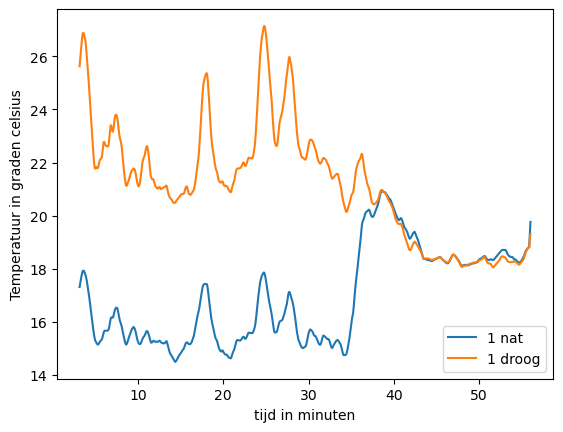

In [21]:
tempAllTowelsFiltered.plot(y=['1 nat', '1 droog'], 
                   xlabel = 'tijd in minuten', 
                   ylabel = 'Temperatuur in graden celsius').legend(['1 nat','1 droog'],loc = 'lower right')
plt.savefig('figures/measurement3/OneTowelResultMeasurement3.png', dpi = 300)

In [22]:
tempAllTowelsFiltered['E'] = tempAllTowelsFiltered['1 droog'] - tempAllTowelsFiltered['1 nat'];
tempAllTowelsFiltered['F'] = tempAllTowelsFiltered['2 droog'] - tempAllTowelsFiltered['2 nat'];
tempAllTowelsFiltered['A'] = tempAllTowelsFiltered['3 droog'] - tempAllTowelsFiltered['3 nat'];
tempAllTowelsFiltered['B'] = tempAllTowelsFiltered['4 droog'] - tempAllTowelsFiltered['4 nat'];
tempAllTowelsFiltered['C'] = tempAllTowelsFiltered['5 droog'] - tempAllTowelsFiltered['5 nat'];
tempAllTowelsFiltered['D'] = tempAllTowelsFiltered['6 droog'] - tempAllTowelsFiltered['6 nat'];


In [23]:
towelMeta = {'A':'Decathlon (blue)',
               'B':'Hema (blue)',
               'C':'Care Plus Travel (blue)',
               'D':'ANWB (green)',
               'E':'Xenos (green)',
               'F':'normal cotton towel'}

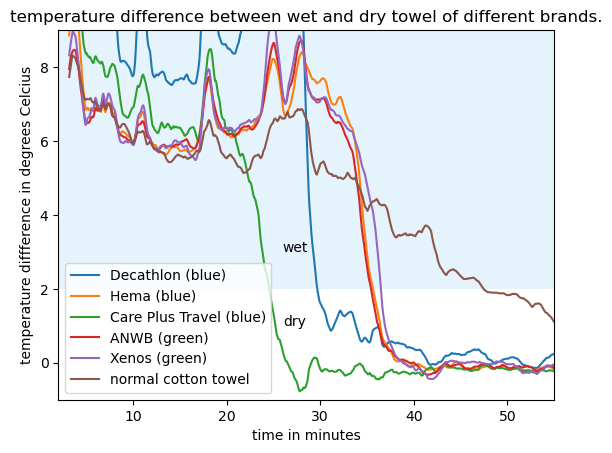

In [24]:
tempAllTowelsFiltered.plot(
    y=['A','B','C','D','E','F']
    ).legend(list(towelMeta.values()),loc = 'lower left')
plt.xlabel('time in minutes')
plt.ylabel('temperature diffference in degrees Celcius')
plt.title('temperature difference between wet and dry towel of different brands.')
plt.ylim(-1,9)
plt.xlim(2,55)

rect = patches.Rectangle([2 , 2], 78, 7, linewidth=1, edgecolor='none', facecolor='#E5F3FD')
ax = plt.gca()
ax.add_patch(rect)
plt.text(26,3,"wet")
plt.text(26,1,"dry")

plt.savefig('figures/measurement3/finalResultMeasurement3.png',dpi = 300)